## Implementing the autoencoder

In [1]:
import pandas as pd

# Load DataFrame from Pickle
df_all_shuffled_training_mass = pd.read_pickle("df_all_shuffled_training_mass.pkl") # training sample

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# #------------------------------------------
# # 1. Load and Prepare the Data
# #------------------------------------------

X=df_all_shuffled_training_mass[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
# # Extract mass separately
# mass = df['mass'].values
mass=df_all_shuffled_training_mass['InvariantMass'].values
# # Create a train/test split
X_train, X_test, mass_train, mass_test = train_test_split(X, mass, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform training data, transform test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [3]:
print(X_train.shape, X_test.shape)


(48000, 6) (12000, 6)


In [4]:
print(X_train.shape[0])


48000


In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
# tf.debugging.set_log_device_placement(True)


TensorFlow version: 2.18.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU (if any)


In [7]:
# #------------------------------------------
# # 2. Define the Autoencoder Model
# #------------------------------------------

input_dim = X_train.shape[1]  # should be 6
encoding_dim = 4              # latent space dimension

# # Input layer
input_layer = Input(shape=(input_dim,))

# # Encoding layer (compression)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# # Decoding layer (reconstruction)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# # Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
# autoencoder.compile(optimizer='adam', loss='mse')
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # best, 185 epochs automatic stop

#------------------------------------------
# 3. Train the Autoencoder
#------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,
    restore_best_weights=True
)

history = autoencoder.fit(X_train, X_train, 
                          epochs=500,
                          # epochs=500,
                          batch_size=256,
                        #   batch_size=64,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=2,
                          callbacks=[early_stopping]
                         )

# with tf.device('/CPU:0'):
#     history = autoencoder.fit(X_train, X_train,
#                               epochs=500,
#                               batch_size=64,
#                               validation_data=(X_test, X_test),
#                               callbacks=[early_stopping],
#                               verbose=2)
#     print(f"Training stopped at epoch {len(history.history['loss'])}")

print(f"Training stopped at epoch {len(history.history['loss'])}")


Epoch 1/500
188/188 - 0s - 2ms/step - loss: 0.0661 - val_loss: 0.0326
Epoch 2/500
188/188 - 0s - 559us/step - loss: 0.0205 - val_loss: 0.0137
Epoch 3/500
188/188 - 0s - 561us/step - loss: 0.0127 - val_loss: 0.0116
Epoch 4/500
188/188 - 0s - 554us/step - loss: 0.0109 - val_loss: 0.0056
Epoch 5/500
188/188 - 0s - 552us/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/500
188/188 - 0s - 551us/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/500
188/188 - 0s - 540us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 8/500
188/188 - 0s - 540us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/500
188/188 - 0s - 597us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 10/500
188/188 - 0s - 698us/step - loss: 0.0032 - val_loss: 0.0032
Epoch 11/500
188/188 - 0s - 548us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 12/500
188/188 - 0s - 550us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 13/500
188/188 - 0s - 583us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 14/500
188/188 - 0s - 563us/step - loss: 0.0029 - val_lo

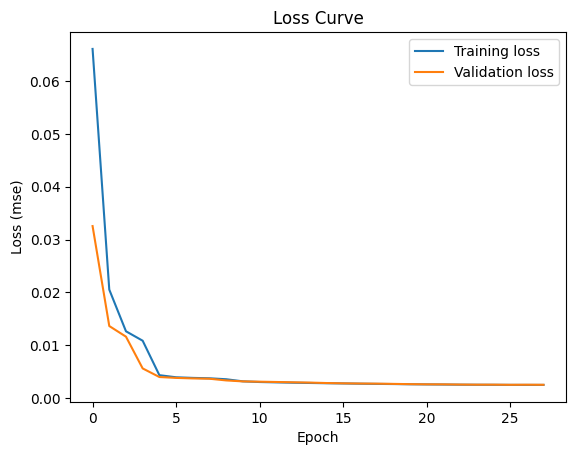

In [8]:
# Optional: Plot the loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (mse)')
plt.title('Loss Curve')
plt.savefig('loss-curve.pdf')
plt.legend()
plt.show()


In [9]:
# #------------------------------------------
# # 4. Use the Autoencoder for Anomaly Detection
# #------------------------------------------

# # Compute reconstruction on the test set
X_test_pred = autoencoder.predict(X_test)

# # Calculate MSE per sample
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
#plot

# You need to define a threshold for what you consider "anomalous"
# This could be determined by analyzing the MSE distribution on training data, for example.
threshold = 1 #np.mean(mse) + 3*np.std(mse)  # Example heuristic

# Find anomalous events
anomalous_indices = np.where(mse > threshold)[0]

#------------------------------------------
# 5. Retrieve the Mass for Anomalous Events
#------------------------------------------

# For any anomalous event, we can now look up its mass
if len(anomalous_indices) > 0:
    print("Anomalous Event Indices:", anomalous_indices)
    print("Mass values for anomalous events:", mass_test[anomalous_indices])
else:
    print("No anomalies detected under this threshold.")


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
No anomalies detected under this threshold.


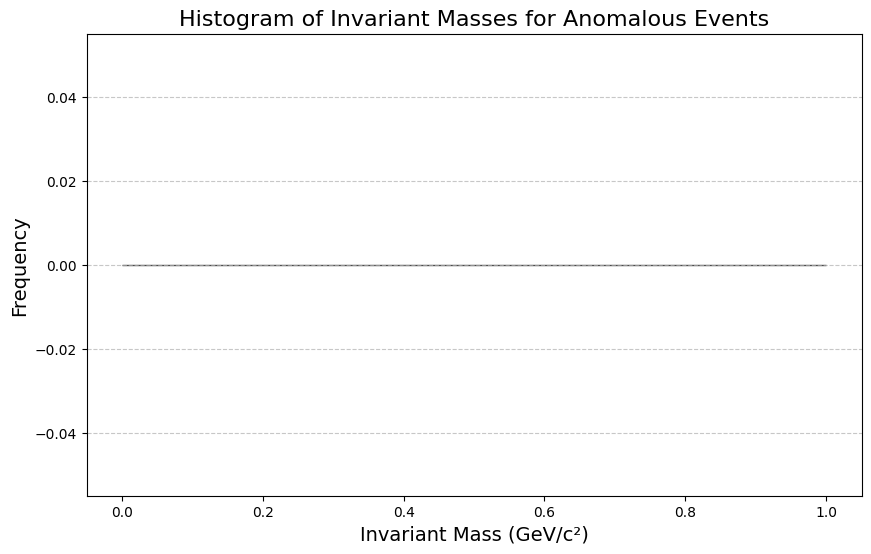

In [10]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(mass_test[anomalous_indices], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Invariant Masses for Anomalous Events', fontsize=16)
plt.xlabel('Invariant Mass (GeV/c²)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.show()


Reconstruction error for anomalous events (label 0):
[0.00103594 0.00168382 0.00174091 ... 0.00247203 0.0009117  0.00253491]


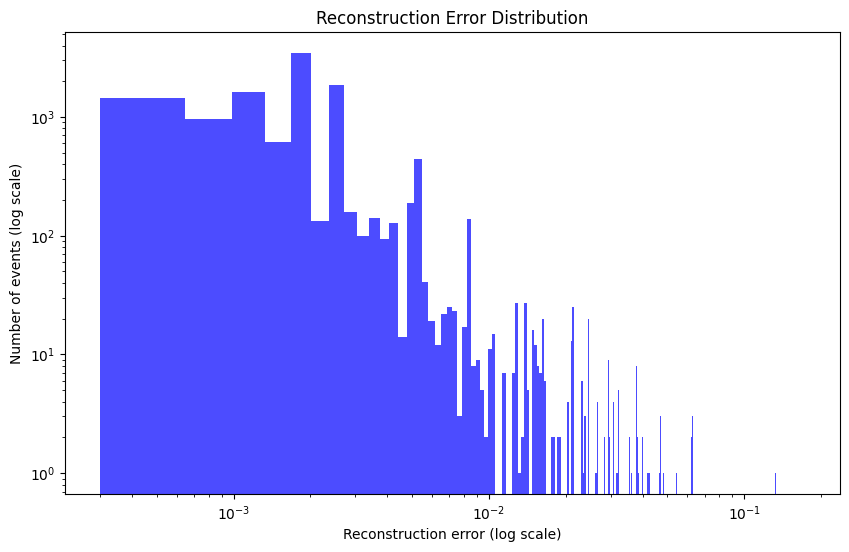

In [11]:
print("\nReconstruction error for anomalous events (label 0):")
print(mse)

# Plot the distributions of reconstruction errors for normal and anomalous events

plt.figure(figsize=(10, 6))
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis
# Plot reconstruction error for normal events
# plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
# plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
# plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.hist(mse, bins=500, alpha=0.7, label="Normal Events", log=True, color = 'blue')  # Increase bins to 200 for finer binning and set log scale for y-axis
#plt.xscale('log')  # Log scale for x-axis
#plt.yscale('log')  # Log scale for y-axis
plt.xlabel("Reconstruction error (log scale)")
plt.ylabel("Number of events (log scale)")
plt.title("Reconstruction Error Distribution")
plt.show()

In [12]:
df_pentaquark_gen3        = pd.read_pickle("df_pentaquark_gen3.pkl")
df_psi2s_muons_pions_gen3 = pd.read_pickle("df_psi2s_muons_pions_gen3.pkl")
df_all_shuffled_nopq_mass = pd.read_pickle("df_all_shuffled_nopq_mass.pkl")     # ALICE, no exotica
df_all_shuffled_mass      = pd.read_pickle("df_all_shuffled_mass.pkl")          # ALICE, with exotica


In [13]:
# Only pentaquarks

Xpq=df_pentaquark_gen3[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
Xpq = scaler.transform(Xpq)

# # Compute reconstruction on the test set
Xpq_pred = autoencoder.predict(Xpq)

# # Calculate MSE per sample
msepq = np.mean(np.power(Xpq - Xpq_pred, 2), axis=1)


# Only Psi(2S)->2mu2pi

Xpsi2s=df_psi2s_muons_pions_gen3[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
Xpsi2s = scaler.transform(Xpsi2s)

Xpsi2s_pred = autoencoder.predict(Xpsi2s)

msepsi2s = np.mean(np.power(Xpsi2s - Xpsi2s_pred, 2), axis=1)


# ALICE, no exotica

X_alice_noexotica=df_all_shuffled_nopq_mass[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
X_alice_noexotica = scaler.transform(X_alice_noexotica)

X_alice_noexotica_pred = autoencoder.predict(X_alice_noexotica)

mse_alice_noexotica = np.mean(np.power(X_alice_noexotica - X_alice_noexotica_pred, 2), axis=1)


# ALICE, with exotica

X_alice_exotica=df_all_shuffled_mass[['El', 'Mu', 'Pi', 'Ka', 'Pr', 'N Tracks']].values
X_alice_exotica = scaler.transform(X_alice_exotica)

X_alice_exotica_pred = autoencoder.predict(X_alice_exotica)

mse_alice_exotica = np.mean(np.power(X_alice_exotica - X_alice_exotica_pred, 2), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5404/5404 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step
5411/5411 ━━━━━━━━━━━━━━━━━━━━ 1s 188us/step


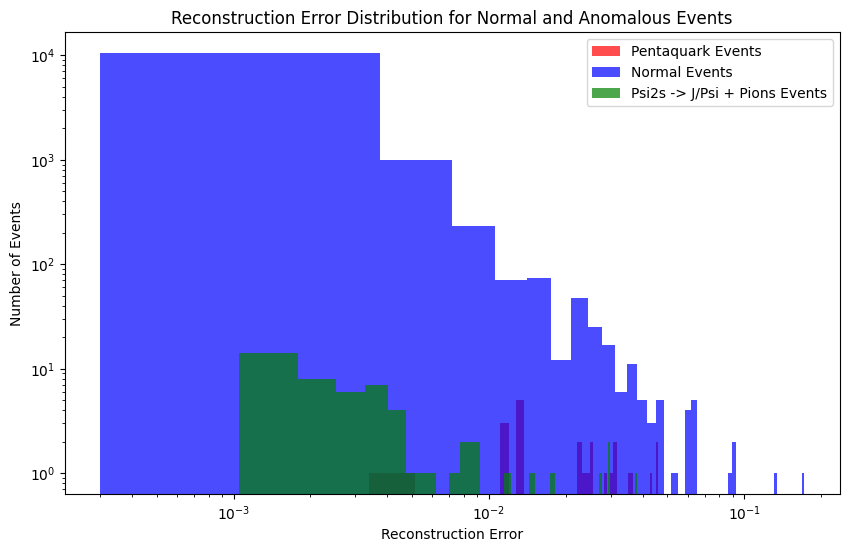

In [14]:
#print("\nReconstruction error for anomalous events (label 0):")
#print(msepq)

# Plot the distributions of reconstruction errors for normal and anomalous events

plt.figure(figsize=(10, 6))
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

# Plot reconstruction error for normal events
plt.hist(msepq, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
plt.hist(mse, bins=50, alpha=0.7, label='Normal Events', color='blue')
plt.hist(msepsi2s, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
#plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
plt.title('Reconstruction Error Distribution for Normal and Anomalous Events')
plt.legend()

# Show the plot
plt.show()

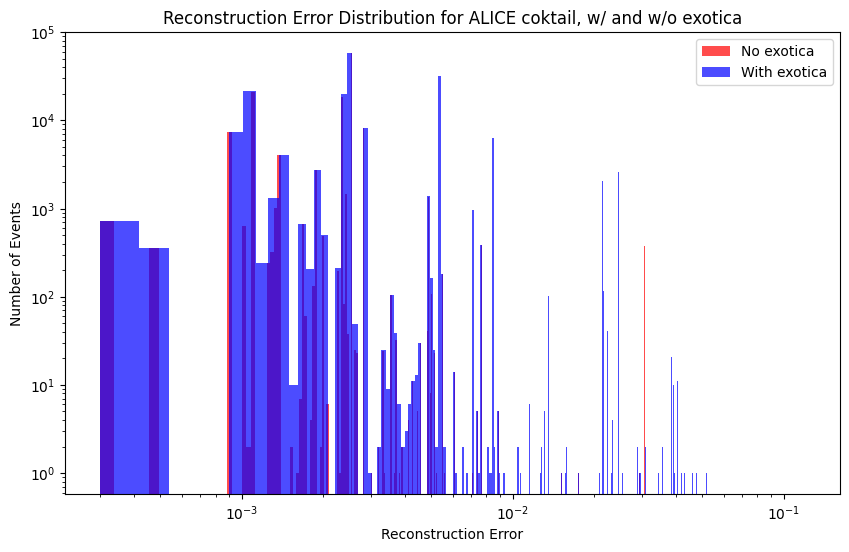

In [15]:
plt.figure(figsize=(10, 6))
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

# Plot reconstruction error for normal events
plt.hist(mse_alice_noexotica, bins=1000, alpha=0.7, label='No exotica', color='red')
plt.hist(mse_alice_exotica, bins=1000, alpha=0.7, label='With exotica', color='blue')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
plt.title('Reconstruction Error Distribution for ALICE coktail, w/ and w/o exotica')
plt.legend()

# Show the plot
plt.show()

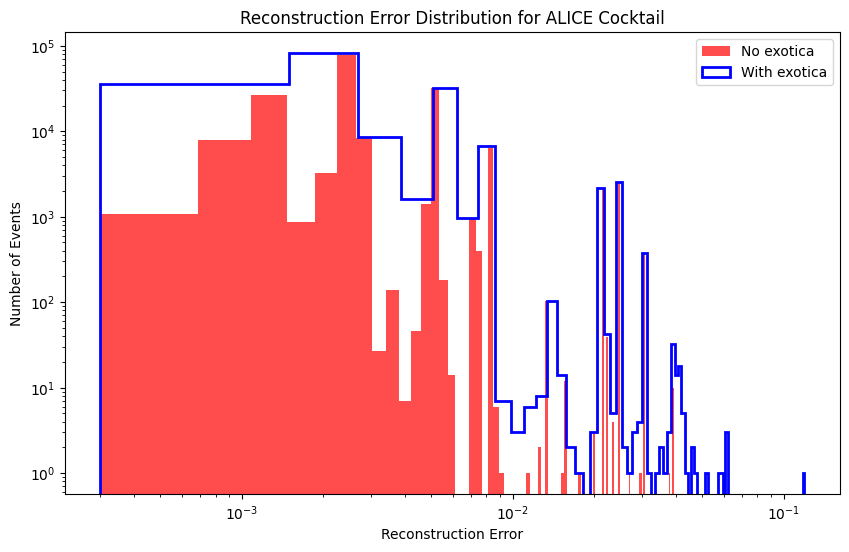

In [16]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.yscale('log')

bins = 100  # Adjust as needed for a less cluttered appearance

# Plot the filled histogram first
plt.hist(mse_alice_noexotica, bins=bins, color='red', alpha=0.7, label='No exotica')

# Then overlay the contour-only histogram
plt.hist(mse_alice_exotica, bins=bins, histtype='step', color='blue', linewidth=2, label='With exotica')

plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
plt.title('Reconstruction Error Distribution for ALICE Cocktail')
plt.legend()
plt.savefig('mse-distribution.pdf')
plt.show()


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


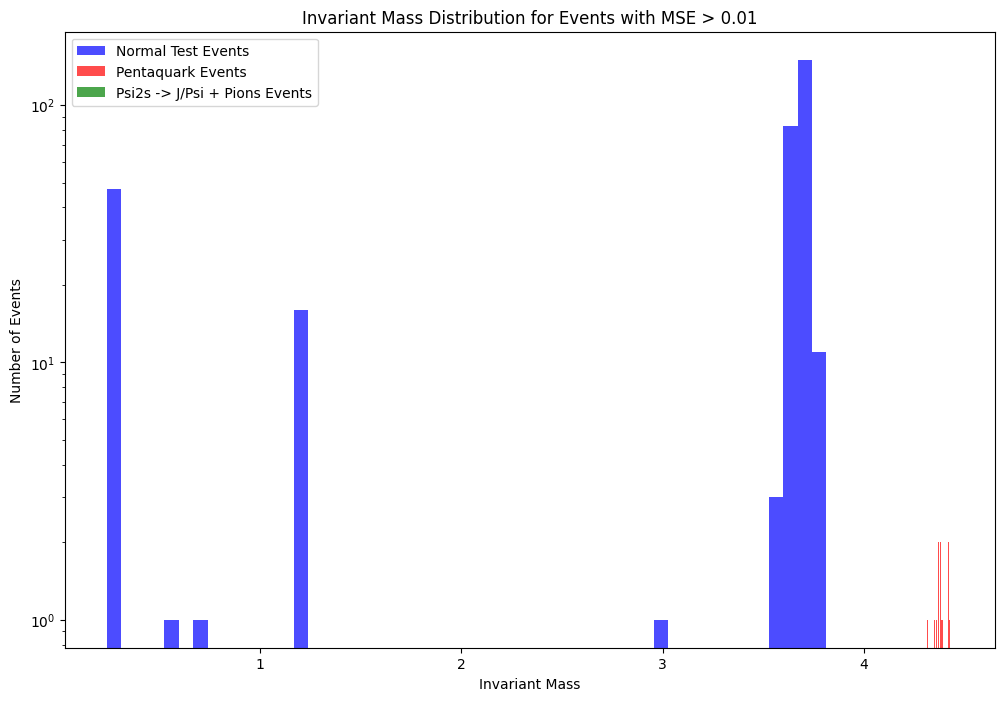

In [17]:
# Set the reconstruction error threshold
mse_threshold = 0.01  # Adjust this value as needed

# Calculate reconstruction error for the test sample
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Filter test events with reconstruction error above the threshold
test_high_mse_indices = mse_test > mse_threshold  # Boolean mask for filtering
test_high_mse_masses = mass_test[test_high_mse_indices]

# Filter pentaquark events with reconstruction error above the threshold
pentaquark_high_mse = df_pentaquark_gen3[msepq > mse_threshold]
pentaquark_masses = pentaquark_high_mse['InvariantMass'].values

# Filter Psi2s -> J/Psi + Pions events with reconstruction error above the threshold
psi2s_high_mse = df_psi2s_muons_pions_gen3[msepsi2s > mse_threshold]
psi2s_masses = psi2s_high_mse['InvariantMass'].values

# Plot the invariant mass distribution
plt.figure(figsize=(12, 8))

plt.hist(test_high_mse_masses, bins=50, alpha=0.7, label='Normal Test Events', color='blue')
plt.hist(pentaquark_masses, bins=50, alpha=0.7, label='Pentaquark Events', color='red')
plt.hist(psi2s_masses, bins=50, alpha=0.7, label='Psi2s -> J/Psi + Pions Events', color='green')

# Add labels and title
plt.xlabel('Invariant Mass')
plt.ylabel('Number of Events')
plt.yscale('log')
plt.title(f'Invariant Mass Distribution for Events with MSE > {mse_threshold}')
plt.legend()

# Show the plot
plt.show()


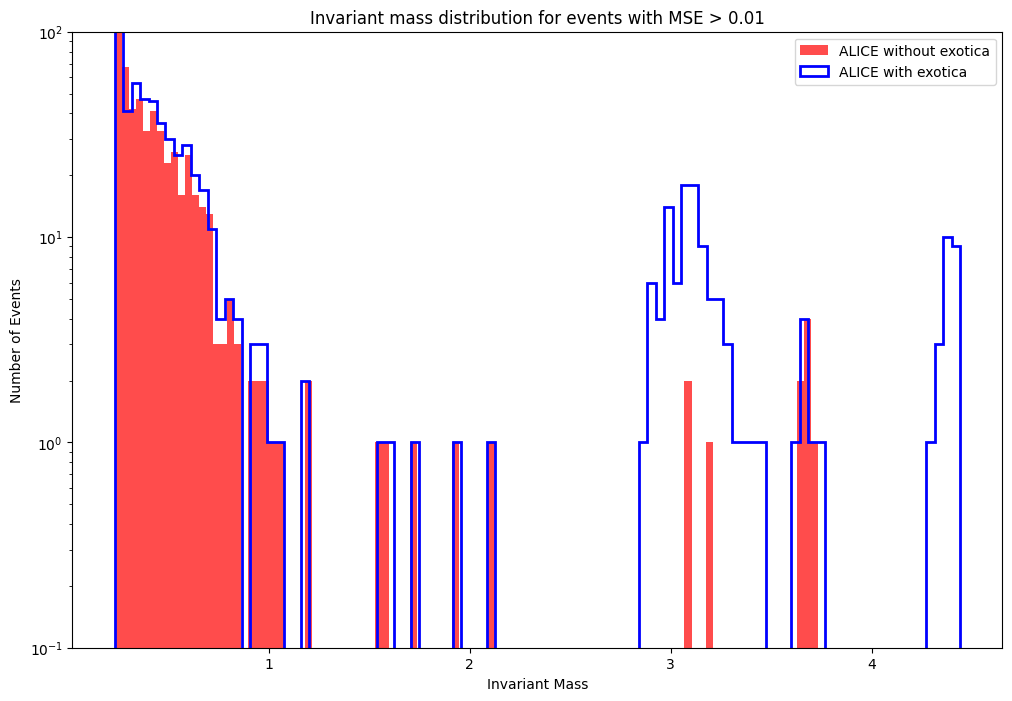

In [18]:
# Filter cocktail no exotica with reconstruction error above the threshold
alice_noexotica_high_mse = df_all_shuffled_nopq_mass[mse_alice_noexotica > mse_threshold]
alice_noexotica_masses = alice_noexotica_high_mse['InvariantMass'].values

# Filter cocktail with exotica with reconstruction error above the threshold
alice_exotica_high_mse = df_all_shuffled_mass[mse_alice_exotica > mse_threshold]
alice_exotica_masses = alice_exotica_high_mse['InvariantMass'].values

# Plot the invariant mass distribution
plt.figure(figsize=(12, 8))

# plt.hist(alice_noexotica_masses, bins=100, alpha=0.7, label='ALICE without exotica', color='blue')
# plt.hist(alice_exotica_masses, bins=100, alpha=0.7, label='ALICE with exotica', color='red')

plt.hist(alice_noexotica_masses, bins=100, color='red', alpha=0.7, label='ALICE without exotica')
plt.hist(alice_exotica_masses, bins=100, histtype='step', color='blue', linewidth=2, label='ALICE with exotica')

ax = plt.gca()
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=2)
# ax.set_xlim([1.5, 5])
ax.set_ylim([0.1, 100])

# Add labels and title
plt.xlabel('Invariant Mass')
plt.ylabel('Number of Events')
plt.yscale('log')
plt.title(f'Invariant mass distribution for events with MSE > {mse_threshold}')
plt.legend()
plt.savefig('mse-inv-mass.pdf')

# Show the plot
plt.show()


In [19]:
count = (alice_exotica_masses > 4).sum()
print(count)


23
